# Examples of how to modify input data to NanoFASE model

This notebook details a number of different options for modifying input to the NanoFASE model, specifically focussing on spatial (and temporal) emissions data.

For a recap on how data input to the NanoFASE model works, see [this slide](https://docs.google.com/presentation/d/1S3-_ea1pGU7F4zP0X6PqphHA5UyWGoQBqg57AE4SJXc). In summary, a separate set of Python scripts ("NanoFASE data module") pre-compiles the data from multiple input files to these files, which are input into the model:
- Config file, which specifies where the rest of the data is. The config file is passed to the model as a command line parameter. [Example file](https://github.com/NERC-CEH/nanofase/blob/flat-data/config/thames_tio2_2015.nml).
- Constants file, which specifies data with no spatial or temporal resolution. [Example file](https://github.com/NERC-CEH/nanofase/blob/flat-data/data/thames/constants_tio2.nml).
- Spatiotemporal data in a NetCDF file. [Example file](https://www.dropbox.com/s/87sc46za77i4sqr/flat_tio2_2015.nc?dl=0).
- **Soon to be deprecated**. Some legacy data is stored in another NetCDF file, which is being deprecated for the main NetCDF file, which is much more efficient. But at this stage, a few variables are still retrieved from this file. [Example file](https://www.dropbox.com/s/690b2xv1mkotyqb/data.nc?dl=0).

## Directly modifying the (main) NetCDF input file

The simplest way to alter (emissions) input data is to edit the NetCDF file directly.

### Areal emissions

For example, say we want to alter the pristine NM emissions to soil. These are stored in the `emissions_areal_soil_pristine` variable. We can use [Rasterio](https://rasterio.readthedocs.io/en/latest/) to have a quick look at the data currently stored in that variable:

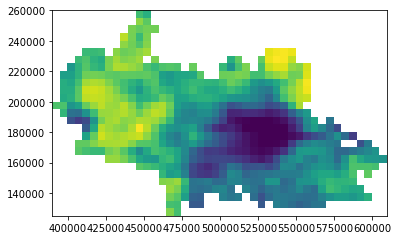

In [2]:
import rasterio as rio
from rasterio.plot import show

%matplotlib inline

# Path to our current NetCDF input file
nc_path = '/home/sharrison/nf/data/processed/model-input/thames/2020-03-20_tio2_2015_corrected-emissions/flat_tio2_2015.nc'

# Rasterio can directly open spatial variables from NetCDF files using the syntax 'netcdf:/path/to/file.nc:variable'
with rio.open(f'netcdf:{nc_path}:emissions_areal_soil_pristine') as rs:
    show(rs)

The above plot is areal pristine NM emissions to soil for the Thames catchment.

To alter the data stored in this variable, we will use the Python netCDF4 library. Firstly, opening the NetCDF file and having a look at its contents:

In [4]:
from netCDF4 import Dataset
from shutil import copyfile

# Make a copy of the input data file so we aren't editing the original
copyfile(nc_path, './data.nc')

nc = Dataset('./data.nc', 'r+')
nc

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    title: Input data for NanoFASE model
    Conventions: CF-1.6
    dimensions(sizes): t(365), x(44), y(27), d(2), w(7), box(4), p(3), l(12)
    variables(dimensions): int32 crs(), int32 t(t), float32 x(x), float32 y(y), int32 grid_shape(d), float32 grid_res(d), float32 grid_bounds(box), int32 flow_dir(y,x), uint8 is_estuary(y,x), int16 outflow(y,x,d), int16 inflows(y,x,w,d), int16 n_waterbodies(y,x), uint8 is_headwater(y,x), float32 soil_bulk_density(y,x), float32 soil_water_content_field_capacity(y,x), float32 soil_water_content_saturation(y,x), float32 soil_hydraulic_conductivity(y,x), float32 soil_texture_clay_content(y,x), float32 soil_texture_sand_content(y,x), float32 soil_texture_silt_content(y,x), float32 soil_texture_coarse_frag_content(y,x), float32 soil_usle_c_factor(y,x), float32 soil_usle_p_factor(y,x), float32 soil_usle_ls_factor(y,x), float32 emissions_areal_soil_pristine(y,x), float3

As you can see, our variable `emissions_areal_soil_pristine` is in the list. We can use the variable name as a key on the NetCDF dataset to retrieve this variable:

In [5]:
# Use the variable name as a key to get the variable from the NetCDF database
var = nc['emissions_areal_soil_pristine']
var

<class 'netCDF4._netCDF4.Variable'>
float32 emissions_areal_soil_pristine(y, x)
    long_name: mass flux of pristine nanomaterial into soil
    units: kg/m**2/timestep
    grid_mapping: crs
unlimited dimensions: 
current shape = (27, 44)
filling on, default _FillValue of 9.969209968386869e+36 used

Modifying this variable is straightforward - we just slice it and assign a new spatial (2D) NumPy array to it. Below we create a randomly filled variable with the same shape (and mask) as the old emissions variable, and then save that to the NetCDF file:

In [6]:
import numpy as np
import numpy.ma as ma

# Use the shape of the old variable to create a new randomly filled variable
new_var = np.random.rand(*var.shape)
# Mask the new variable using the old variable's mask
new_var = ma.masked_array(new_var, mask=var[:].mask)
# Change the variable in the NetCDF file to be the new randomly filled variable
var[:] = new_var
nc.close()

We can test this has worked by closing and then plotting the new NetCDF file. We should get a raster with randomly filled grid cells.

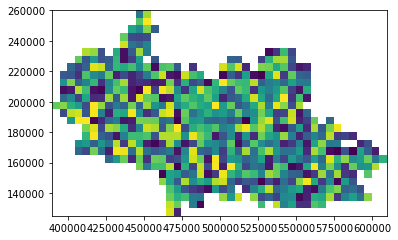

In [11]:
with rio.open('netcdf:./data.nc:emissions_areal_soil_pristine') as rs:
    show(rs)

More useful than this is to use a **GeoTIFF** file to fill the variable. In the following, we presume the GeoTIFF file is the same dimensions and projection as the current dataset. Firstly, use Rasterio to get a masked array of the new data:

In [ ]:
with rio.open('') as rs: